# Tuesday Health: Hospice Quality Metrics Technical Assessment
Author: Kyle Biron  

### Imports

In [32]:
import duckdb
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# configure pandas to show full string values and all rows/columns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Connect to db

In [33]:
# set duckdb directory path
db_dir = "/Users/kyle/Documents/personal_projects/repos/kyle-tuesday-health-tech-assignment/hospice_quality_metrics/db"

# connect to an existing duckdb database
con = duckdb.connect(f'{db_dir}/hospice_quality_metrics.db')

# list and print all tables in the connected duckdb database
tables = con.execute("SHOW TABLES").df()
print(tables)

                                              name
0                  fact_hospice_provider_flattened
1  fact_hospice_provider_missing_metrics_by_region
2                             stg_hospice_provider
3                   stg_hospice_provider_flattened


In [22]:
stg_hospice_provider_flattened_df = con.execute("SELECT * FROM stg_hospice_provider_flattened").df()

sorted_columns = sorted(stg_hospice_provider_flattened_df.columns)
print(", ".join(sorted_columns))

Average_Daily_Census, Bene_Dual_Pct, Bene_MA_Pct, Care_Provided_Assisted_Living, Care_Provided_Home, Care_Provided_Inpatient_Hospice, Care_Provided_Inpatient_Hospital, Care_Provided_Nursing_Facility, Care_Provided_Skilled_Nursing, Care_Provided_other_locations, H_001_01_DENOMINATOR, H_001_01_OBSERVED, H_002_01_DENOMINATOR, H_002_01_OBSERVED, H_003_01_DENOMINATOR, H_003_01_OBSERVED, H_004_01_DENOMINATOR, H_004_01_OBSERVED, H_005_01_DENOMINATOR, H_005_01_OBSERVED, H_006_01_DENOMINATOR, H_006_01_OBSERVED, H_007_01_DENOMINATOR, H_007_01_OBSERVED, H_008_01_DENOMINATOR, H_008_01_OBSERVED, H_011_01_DENOMINATOR, H_011_01_OBSERVED, H_012_00_OBSERVED, H_012_01_DENOMINATOR, H_012_01_OBSERVED, H_012_01_PERCENTILE, H_012_02_DENOMINATOR, H_012_02_OBSERVED, H_012_02_PERCENTILE, H_012_03_DENOMINATOR, H_012_03_OBSERVED, H_012_03_PERCENTILE, H_012_04_DENOMINATOR, H_012_04_OBSERVED, H_012_04_PERCENTILE, H_012_05_DENOMINATOR, H_012_05_OBSERVED, H_012_05_PERCENTILE, H_012_06_DENOMINATOR, H_012_06_OBSERVED,

### 1. Correlation Analysis: HIS Composite Process Metric & HCI Decile

#### load ```fact_hospice_provider_flattened``` to a df

- ```fact_hospice_provider_flattened``` is the flattened table from ```hospice_quality_metrics.db``` 
    - ```h_008_01_observed``` is the HIS Composite Measure
    - ```h_012_00_observed``` is the HCI Decile
- This dataframe will be used for the correlation analysis between the two measures
- Note that executing the ```corr()``` pandas method only retains the CCNs that have BOTH measures populated
    - A side-analyis (see appendix) shows that out of the 7132 CCNs, **2765 (or ~39%)** of CCNs were excluded for this correlation analysis
    - CMS Region 9 (San Francisco: Arizona, California, Hawaii, Nevada, Pacific
Territories) was primarily impacted with this exclusion, as **63.36%** of their CCNs were missing at least one measure 

In [37]:
# use con.execute() to create a df
fact_hospice_provider_flattened_df = con.execute("SELECT * FROM fact_hospice_provider_flattened").df()

# preview the df
fact_hospice_provider_flattened_df.head(5)

,ccn,cms_region,h_001_01_denominator,h_001_01_observed,h_002_01_denominator,h_002_01_observed,h_003_01_denominator,h_003_01_observed,h_004_01_denominator,h_004_01_observed,h_005_01_denominator,h_005_01_observed,h_006_01_denominator,h_006_01_observed,h_007_01_denominator,h_007_01_observed,h_008_01_denominator,h_008_01_observed,h_011_01_denominator,h_011_01_observed,h_012_00_observed,h_012_01_denominator,h_012_01_observed,h_012_01_percentile,h_012_02_denominator,h_012_02_observed,h_012_02_percentile,h_012_03_denominator,h_012_03_observed,h_012_03_percentile,h_012_04_denominator,h_012_04_observed,h_012_04_percentile,h_012_05_denominator,h_012_05_observed,h_012_05_percentile,h_012_06_denominator,h_012_06_observed,h_012_06_percentile,h_012_07_denominator,h_012_07_observed,h_012_07_percentile,h_012_08_denominator,h_012_08_observed,h_012_08_percentile,h_012_09_denominator,h_012_09_observed,h_012_09_percentile,h_012_10_denominator,h_012_10_observed,h_012_10_percentile,average_daily_census,bene_dual_pct,bene_ma_pct,care_provided_assisted_living,care_provided_home,care_provided_inpatient_hospice,care_provided_inpatient_hospital,care_provided_nursing_facility,care_provided_skilled_nursing,care_provided_other_locations,pct_pts_w_cancer,pct_pts_w_circ_heart_disease,pct_pts_w_dementia,pct_pts_w_resp_disease,pct_pts_w_stroke,pct_pts_w_other_conditions,provided_home_care_and_other,provided_home_care_only
0,A11505,9,212,100.0,212,100.0,212,100.0,114,50.0,212,100.0,172,100.0,40,97.5,212,72.6,39,10.3,8.0,"23,760",1.4,90,150,92.0,97,145,4.1,34,145,52.4,81,145,14.5,84,145,4.1,82,204,"25,977",90,"23,434",9.4,18,"221,010",8.0,50,77,84.4,19,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,A11522,9,67,100.0,67,100.0,67,100.0,8,None,67,100.0,66,100.0,5,None,67,100.0,None,None,9.0,"12,152",2.4,94,86,47.7,37,130,23.1,98,130,23.1,13,130,3.1,30,130,0.8,44,152,"19,707",72,"11,869",16.2,83,"192,345",29.6,100,77,88.3,28,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,A11524,9,109,99.1,109,99.1,109,98.2,23,95.7,109,98.2,63,100.0,16,None,109,92.7,78,2.6,7.0,"15,775",0.0,49,118,100,100,50,6.0,48,50,36.0,41,50,6.0,46,50,2.0,59,185,"17,251",59,"15,769",5.4,2,"85,500",12.1,83,100,64.0,5,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,A11539,9,77,98.7,77,98.7,77,98.7,26,73.1,77,98.7,58,100.0,5,None,77,88.3,31,12.9,9.0,"11,743",0.4,78,88,79.5,86,68,10.3,77,68,25.0,16,68,10.3,70,68,1.5,52,135,"18,123",64,"11,711",11.2,37,"131,130",25.9,99,56,67.9,6,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,A11540,9,60,100.0,60,100.0,60,100.0,41,92.7,60,100.0,54,100.0,7,None,60,91.7,None,None,10.0,"3,665",0.0,49,27,44.4,32,32,0.0,18,32,37.5,45,32,3.1,30,32,0.0,41,31,"25,321",89,"3,665",9.4,18,"34,305",17.0,93,4,100,100,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


#### Examining the distribution of HIS Composite Measure and HCI Decile

- The plots below display the distribution for both measures
- Both measures appear right-skewed, with most of the CCNs yeilding higher performance

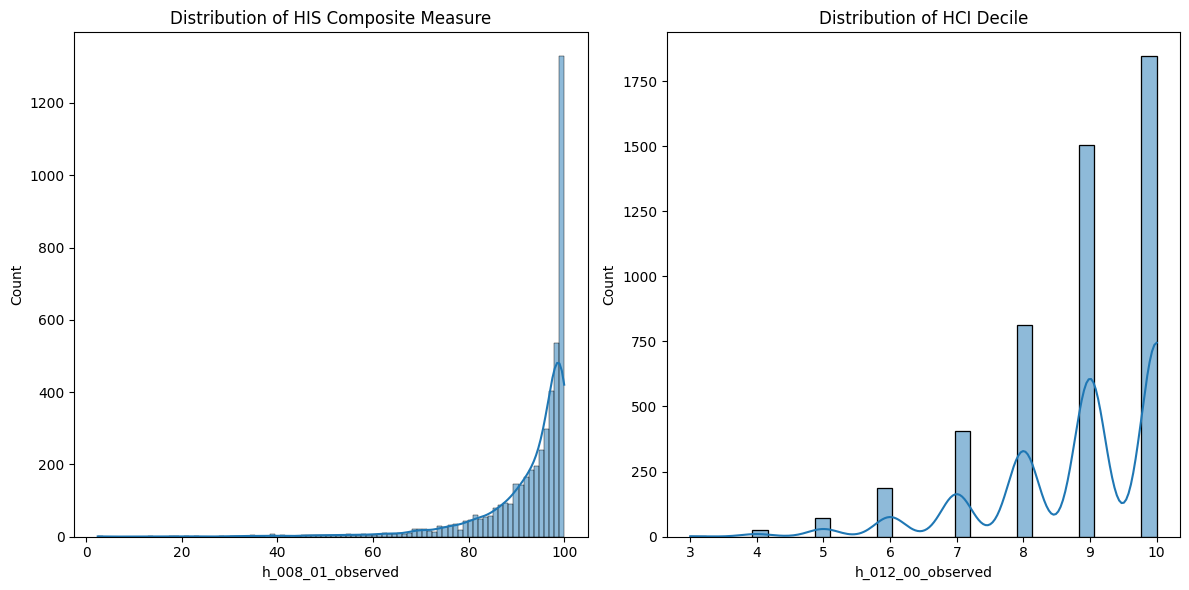

In [40]:
# configure subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# HIS Composite Measure plot
sns.histplot(data=fact_hospice_provider_flattened_df, x="h_008_01_observed", kde=True, ax=axes[0])
axes[0].set_title('Distribution of HIS Composite Measure')

# HCI Decile plot
sns.histplot(data=fact_hospice_provider_flattened_df, x="h_012_00_observed", kde=True, ax=axes[1])
axes[1].set_title('Distribution of HCI Decile')

# show plots
plt.tight_layout()
plt.show()

#### Evaluating the correlation between HIS composite measure and HCI decile

- Initially included only the Pearson correlation coefficient, but since the metric distributions did not meet the normal distribution assumption, the Spearman correlation coefficient was also included
  - The Anderson-Darling test for normality was not used to confirm, but we can clearly see from the histograms that the distributions are not normal 
- Both correlation coefficients (**~0.22**) indicate a **weak positive relationship**, which suggests that these two measures may fundamentally reflect different signals of hospice care quality 

In [41]:
# Pearson correlation
correlation_pearson = fact_hospice_provider_flattened_df[['h_008_01_observed', 'h_012_00_observed']].corr()

# Spearman correlation
correlation_spearman = fact_hospice_provider_flattened_df[['h_008_01_observed', 'h_012_00_observed']].corr(method='spearman')

# report out correlation coefficients
print("Correlation Matrix: Pearson\n")
print(correlation_pearson)
print("\n" + "-"*50 + "\n") 
print("Correlation Matrix: Spearman\n")
print(correlation_spearman)

Correlation Matrix: Pearson

                   h_008_01_observed  h_012_00_observed
h_008_01_observed           1.000000           0.223246
h_012_00_observed           0.223246           1.000000

--------------------------------------------------

Correlation Matrix: Spearman

                   h_008_01_observed  h_012_00_observed
h_008_01_observed           1.000000           0.227345
h_012_00_observed           0.227345           1.000000


- Even by evaluating the Spearman coefficient by ```cms_region```, we do not observe any significant improvement in the correlation between the HIS composite measure and the HCI decile
- Region 10 has arguably the "strongest" relationship (**~0.28**) between HIS composite measure and the HCI decile, whereas Region 4 has little to no relationship (**~0.04**)
    - 10 = Seattle: Alaska, Idaho, Oregon, Washington
    - 4 = Atlanta: Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, Tennessee      

In [42]:

# Spearman correlation by region
correlation_spearman_by_region = fact_hospice_provider_flattened_df.groupby('cms_region')[
    ['h_008_01_observed', 'h_012_00_observed']
].corr(method='spearman')

# report out correlation coefficients
print("Correlation Matrix: Spearman by cms_region\n")
print(correlation_spearman_by_region)

Correlation Matrix: Spearman by cms_region

                              h_008_01_observed  h_012_00_observed
cms_region                                                        
1          h_008_01_observed           1.000000           0.174107
           h_012_00_observed           0.174107           1.000000
2          h_008_01_observed           1.000000           0.205653
           h_012_00_observed           0.205653           1.000000
3          h_008_01_observed           1.000000           0.253217
           h_012_00_observed           0.253217           1.000000
4          h_008_01_observed           1.000000           0.044258
           h_012_00_observed           0.044258           1.000000
5          h_008_01_observed           1.000000           0.155562
           h_012_00_observed           0.155562           1.000000
6          h_008_01_observed           1.000000           0.231899
           h_012_00_observed           0.231899           1.000000
7          h_008_0

In summary:
- HIS composite measure and HCI decile are only **slightly** related (positive direction)
- **Pros** of HIS composite process metric
  - HIS captures patient-level data on admissions and discharges, which indicates more of a process-specific measure
  - Being a process-specific measure facilitates easier data collection for CCNs
  - References: [HIS Manual](https://www.cms.gov/files/document/hismanualv302apr152024.pdf)
- **Cons** of HIS composite process metric
  - Again, since this measure captures data on admissions and discharges, signals regarding cost and utilization may not be captured
  - In other words, there are CCNs who perform well on adhering to the administrative processes of admission/discharges, but perform poorly on cost/utilization/outcomes (i.e. CCN:111743, HIS: 100, HIC: 4.0)
  - Scatterplot below highlights some of these patterns
  - In general (not just specific to HIS), there is variability of measure availability across all **cms_region**, indicating some regions have less hospice resources and than others 

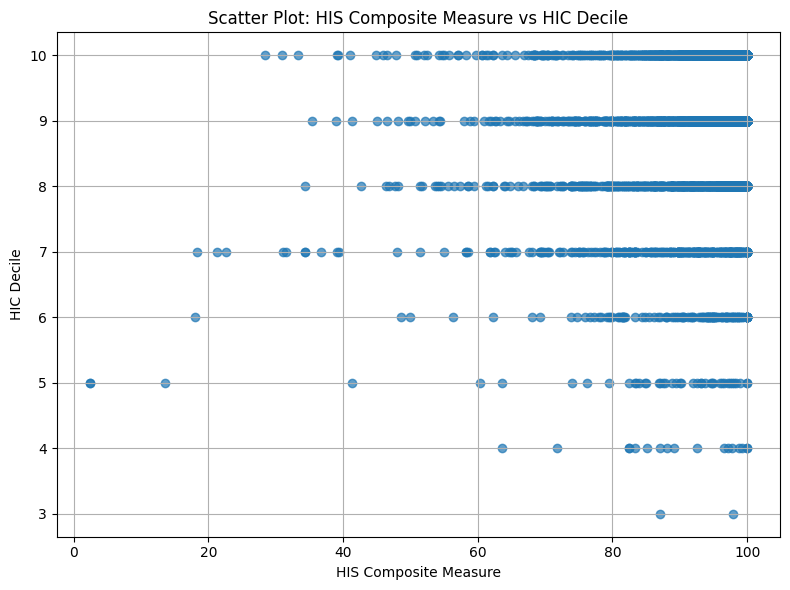

In [43]:
plt.figure(figsize=(8, 6))

# Create a scatter plot
plt.scatter(fact_hospice_provider_flattened_df['h_008_01_observed'], 
            fact_hospice_provider_flattened_df['h_012_00_observed'], 
            alpha=0.7)

# Set the title and labels
plt.title('Scatter Plot: HIS Composite Measure vs HIC Decile')
plt.xlabel('HIS Composite Measure')
plt.ylabel('HIC Decile')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

### Appendix

####  CCNs without having both HIS and HCI by region

referenced from the data dictionary:  
- 1 = Boston: Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont  
- 2 = New York: New Jersey, New York, Puerto Rico, Virgin Islands  
- 3 = Philadelphia: Delaware, District of Columbia, Maryland, Pennsylvania, Virginia, West Virginia  
- 4 = Atlanta: Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, Tennessee  
- 5 = Chicago: Illinois, Indiana, Michigan, Minnesota, Ohio, Wisconsin  
- 6 = Dallas: Arkansas, Louisiana, New Mexico, Oklahoma, Texas  
- 7 = Kansas City: Iowa, Kansas, Missouri, Nebraska  
- 8 = Denver: Colorado, Montana, North Dakota, South Dakota, Utah, Wyoming  
- 9 = San Francisco: Arizona, California, Hawaii, Nevada, Pacific Territories  
- 10 = Seattle: Alaska, Idaho, Oregon, Washington

<Figure size 1000x600 with 0 Axes>

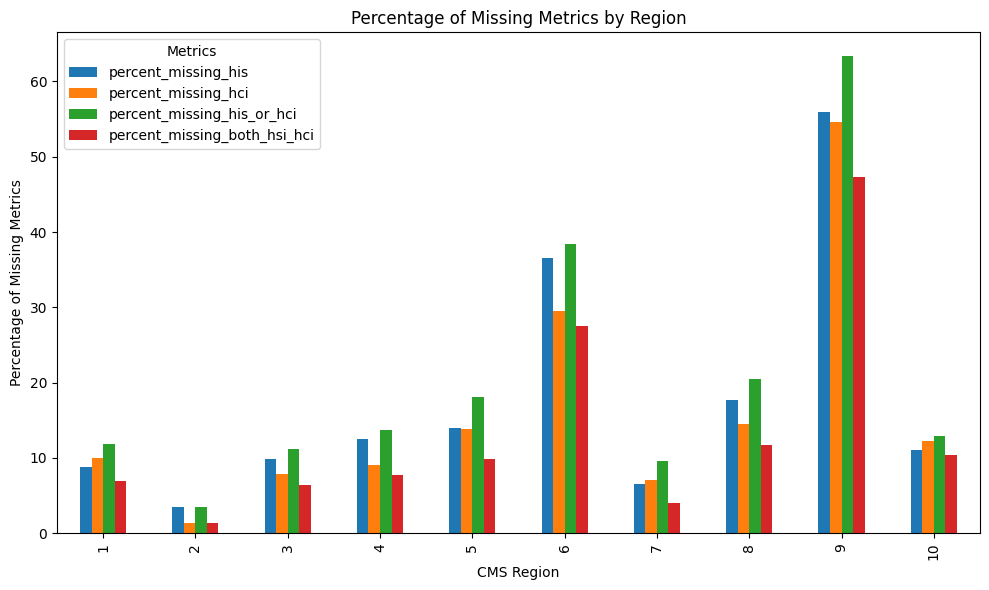

In [35]:
# use con.execute() to create a df
fact_hospice_provider_missing_metrics_by_region_df = con.execute("SELECT * FROM fact_hospice_provider_missing_metrics_by_region").df()

# sort df by cms_region
fact_hospice_provider_missing_metrics_by_region_df = fact_hospice_provider_missing_metrics_by_region_df.sort_values('cms_region')

# configure size
plt.figure(figsize=(10, 6))

# bar chart
fact_hospice_provider_missing_metrics_by_region_df.plot(
    kind='bar', 
    x='cms_region', 
    y=['percent_missing_his', 'percent_missing_hci', 'percent_missing_his_or_hci', 'percent_missing_both_hsi_hci'], 
    figsize=(10, 6)
)

# configure title and labels
plt.title('Percentage of Missing Metrics by Region')
plt.xlabel('CMS Region')
plt.ylabel('Percentage of Missing Metrics')

# show plot
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

In [34]:
adhoc_query = '''

select 
        *
    from fact_hospice_provider_missing_metrics_by_region
    limit 10

'''

con.execute(adhoc_query).df()

,cms_region,total_missing_his,total_is_missing_hci,total_missing_his_or_hci,total_is_missing_both_hsi_hci,total_denominator,percent_missing_his,percent_missing_hci,percent_missing_his_or_hci,percent_missing_both_hsi_hci
0,1,14.0,16.0,19.0,11.0,160.0,8.75,10.00,11.88,6.88
1,2,5.0,2.0,5.0,2.0,144.0,3.47,1.39,3.47,1.39
2,3,35.0,28.0,40.0,23.0,358.0,9.78,7.82,11.17,6.42
3,4,90.0,65.0,99.0,56.0,722.0,12.47,9.00,13.71,7.76
4,5,100.0,99.0,129.0,70.0,716.0,13.97,13.83,18.02,9.78
5,6,516.0,417.0,544.0,389.0,1414.0,36.49,29.49,38.47,27.51
6,7,21.0,23.0,31.0,13.0,324.0,6.48,7.10,9.57,4.01
7,8,44.0,36.0,51.0,29.0,249.0,17.67,14.46,20.48,11.65
8,9,1614.0,1575.0,1826.0,1363.0,2882.0,56.00,54.65,63.36,47.29
9,10,18.0,20.0,21.0,17.0,163.0,11.04,12.27,12.88,10.43


In [44]:
con.close()